In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq, newton
import math
from statistics import NormalDist

# Vołcanic Rock Analysis

In [2]:
day0 = pl.read_csv("round-3-island-data-bottle\prices_round_3_day_0.csv", separator=";")
day1 = pl.read_csv("round-3-island-data-bottle\prices_round_3_day_1.csv", separator=";")
day2 = pl.read_csv("round-3-island-data-bottle\prices_round_3_day_2.csv", separator=";")

day0 = day0.with_columns(pl.col("timestamp").alias("time"))
day1 = day1.with_columns(pl.col("timestamp").add((1) * int(1e6)).alias("time"))
day2 = day2.with_columns(pl.col("timestamp").add((2) * int(1e6)).alias("time"))
combined = pl.concat([day0, day1, day2], how="vertical")
combined = combined.pivot(
    index="time",
    on="product",
    values="mid_price",
)

T = 8  # days to expiration
# Pivot the dataframe to wide format
combined.describe()

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Henry\AppData\Local\Temp\ipykernel_1284\3092768587.py:1: SyntaxWarning: invalid escape sequence '\p'
  day0 = pl.read_csv("round-3-island-data-bottle\prices_round_3_day_0.csv", separator=";")
C:\Users\Henry\AppData\Local\Temp\ipykernel_1284\3092768587.py:2: SyntaxWarning: invalid escape sequence '\p'
  day1 = pl.read_csv("round-3-island-data-bottle\prices_round_3_day_1.csv", separator=";")
C:\Users\Henry\AppData\Local\Temp\ipykernel_1284\3092768587.py:3: SyntaxWarning: invalid escape sequence '\p'
  day2 = pl.read_csv("round-3-island-data-bottle\prices_round_3_day_2.csv", separator=";")


statistic,time,VOLCANIC_ROCK_VOUCHER_10500,DJEMBES,CROISSANTS,JAMS,VOLCANIC_ROCK_VOUCHER_10000,KELP,VOLCANIC_ROCK_VOUCHER_9750,PICNIC_BASKET1,PICNIC_BASKET2,VOLCANIC_ROCK_VOUCHER_9500,RAINFOREST_RESIN,VOLCANIC_ROCK_VOUCHER_10250,SQUID_INK,VOLCANIC_ROCK
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.49995e6,40.678183,13396.3034,4276.514717,6542.659983,342.96975,2043.15135,583.3416,58741.015433,30213.9483,832.331917,10000.027133,147.65635,1874.215967,10332.012333
"""std""",866039.837421,33.11181,64.785807,24.545114,45.452309,131.623753,8.44881,140.773534,324.368301,163.93151,141.647684,2.187778,90.379699,47.260689,141.716764
"""min""",0.0,1.0,13263.5,4232.0,6470.0,88.5,2024.5,285.5,58169.5,29926.5,529.5,9994.5,13.5,1734.5,10028.5
"""25%""",750000.0,6.5,13364.5,4258.5,6513.5,213.5,2035.5,450.5,58462.5,30076.5,699.5,10000.0,52.5,1841.5,10199.0
"""50%""",1.5e6,44.5,13391.5,4271.0,6526.0,394.0,2044.5,639.5,58671.5,30178.5,888.5,10000.0,176.5,1871.5,10388.0
"""75%""",2.2499e6,68.5,13447.0,4296.5,6566.5,455.5,2049.5,703.5,59041.5,30363.5,952.5,10000.0,225.5,1909.5,10452.5
"""max""",2.9999e6,144.5,13519.5,4328.5,6641.5,587.5,2065.5,836.0,59399.5,30536.5,1085.5,10005.5,345.5,1986.5,10585.5


In [3]:
from scipy.stats import norm


def black_scholes_call(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility**2) * time_to_expiry) / (
        volatility * np.sqrt(time_to_expiry)
    )
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    call_price = spot * norm.cdf(d1) - strike * norm.cdf(d2)
    return call_price


def implied_volatility(call_price, spot, strike, time_to_expiry):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to find the root of the equation
    implied_vol = brentq(equation, -1e-10, 1.0, xtol=1e-10)
    return implied_vol


def iv_calc(strike):
    # convert padnas columns to numpy array
    spot = combined["VOLCANIC_ROCK"].to_numpy()
    call_price = combined[f"VOLCANIC_ROCK_VOUCHER_{strike}"].to_numpy()
    timestamp = combined["time"].to_numpy()
    tte = (T - (timestamp / 1e6)) / 365  # Convert timestamp to years
    implied_vols = [
        implied_volatility(price, s, strike, t)
        for price, s, t in zip(call_price, spot, tte)
    ]
    moneyness = np.log(strike / spot) / np.sqrt(tte)
    plt.scatter(moneyness, implied_vols, label=f"Strike {strike}")
    return moneyness, implied_vols, timestamp


# for strike in [9500, 9750, 10000, 10250, 10500]:
#     print(strike)
#     moneyness, implied_vols, timestamps = iv_calc(strike)
#     # combine with results dataframe
#     combined = combined.with_columns(
#         pl.Series(name=f"moneyness_{strike}", values=moneyness),
#         pl.Series(name=f"implied_vols_{strike}", values=implied_vols),
#     )


In [4]:
# save dataframe as parquet
# combined.write_parquet("round-3-island-data-bottle/iv_data.parquet")
combined = pl.read_parquet("round-3-island-data-bottle/iv_data.parquet")

coefficients: [0.23797068 0.00266612 0.14938434]


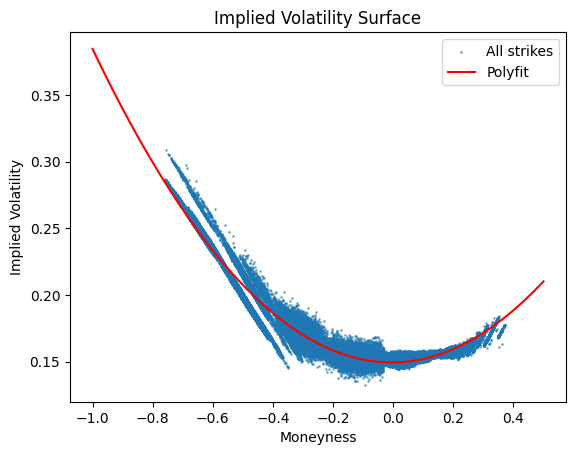

In [5]:
removed_outliers = combined.filter(
    (pl.col("implied_vols_9500") > 0.1)
    & (pl.col("implied_vols_9750") > 0.1)
    & (pl.col("implied_vols_10000") > 0.1)
    & (pl.col("implied_vols_10250") > 0.1)
    & (pl.col("implied_vols_10500") > 0.1)
)

all_iv = np.concatenate(
    [
        removed_outliers[f"implied_vols_{strike}"].to_numpy()
        for strike in [9500, 9750, 10000, 10250, 10500]
    ]
)
all_moneyness = np.concatenate(
    [
        removed_outliers[f"moneyness_{strike}"].to_numpy()
        for strike in [9500, 9750, 10000, 10250, 10500]
    ]
)
plt.scatter(all_moneyness, all_iv, label="All strikes", s=1, alpha=0.5)
plt.xlabel("Moneyness")
plt.ylabel("Implied Volatility")

poly_fit = np.polyfit(all_moneyness, all_iv, 2)
x_range = np.linspace(-1, 0.5, 100)
y_fit = np.polyval(poly_fit, x_range)
plt.plot(x_range, y_fit, color="red", label="Polyfit")
plt.legend()
plt.title("Implied Volatility Surface")
print(f"coefficients: {poly_fit}")

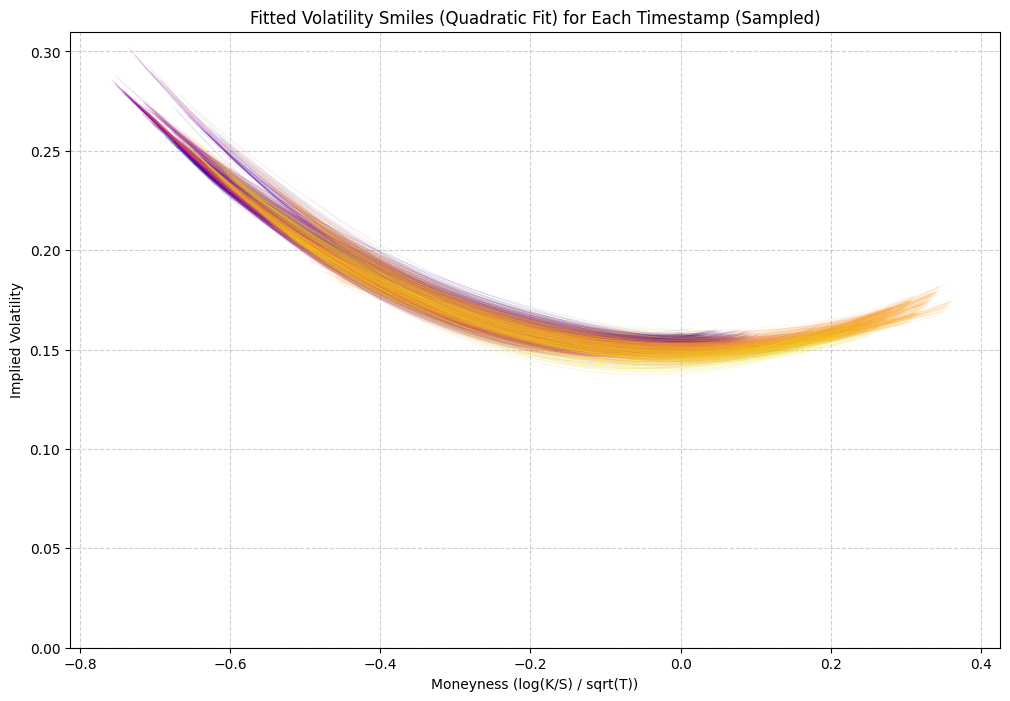

In [12]:
# Define the strikes used
strikes = [9500, 9750, 10000, 10250, 10500]

# Create moneyness and implied volatility column names
moneyness_cols = [f"moneyness_{k}" for k in strikes]
iv_cols = [f"implied_vols_{k}" for k in strikes]

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate through each timestamp (row) in the results dataframe
# Plotting every curve can be very dense, so let's plot every 100th curve
plot_step = 10
zeros = []
a = []
b = []
c = []
for i in range(0, len(combined), plot_step):
    # Extract moneyness and IV values for the current timestamp across all strikes
    moneyness_values = combined[moneyness_cols]
    moneyness_values = moneyness_values.row(i)

    iv_values = combined[iv_cols]
    iv_values = iv_values.row(i)
    found = False
    for v in iv_values:
        if v < 0.1:
            found = True
            break
    if found:
        continue
    # Convert to numpy arrays
    moneyness_np = np.array(moneyness_values)
    iv_np = np.array(iv_values)

    # Filter out any potential NaN/inf values if necessary (optional, depends on data quality)
    valid_indices = np.isfinite(moneyness_np) & np.isfinite(iv_np)
    moneyness_np = moneyness_np[valid_indices]
    iv_np = iv_np[valid_indices]

    # Ensure we have enough points to fit a quadratic curve
    if len(moneyness_np) >= 3:
        # Fit a quadratic polynomial (degree 2)
        coeffs = np.polyfit(moneyness_np, iv_np, 2)

        # Generate a range of moneyness values for plotting the fitted curve
        x_fit = np.linspace(moneyness_np.min(), moneyness_np.max(), 100)

        # Calculate the corresponding implied volatility values using the fitted polynomial
        y_fit = np.polyval(coeffs, x_fit)
        zeros.append(np.polyval(coeffs, 0))
        a.append(coeffs[0])
        b.append(coeffs[1])
        c.append(coeffs[2])
        # Get a colormap (e.g., 'viridis', 'plasma', 'coolwarm')
        cmap = plt.get_cmap("plasma")
        # Normalize the current timestamp index (i) to the range [0, 1] for the colormap
        # len(result) gives the total number of timestamps
        normalized_time = i / len(combined)
        plot_color = cmap(normalized_time)

        # Plot the fitted curve for the current timestamp
        # Use low alpha to handle potential overplotting and the calculated color
        plt.plot(x_fit, y_fit, lw=0.5, alpha=0.1, color=plot_color)

# Add labels and title
plt.xlabel("Moneyness (log(K/S) / sqrt(T))")
plt.ylabel("Implied Volatility")
plt.title("Fitted Volatility Smiles (Quadratic Fit) for Each Timestamp (Sampled)")
plt.ylim(bottom=0)  # Volatility should not be negative
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()

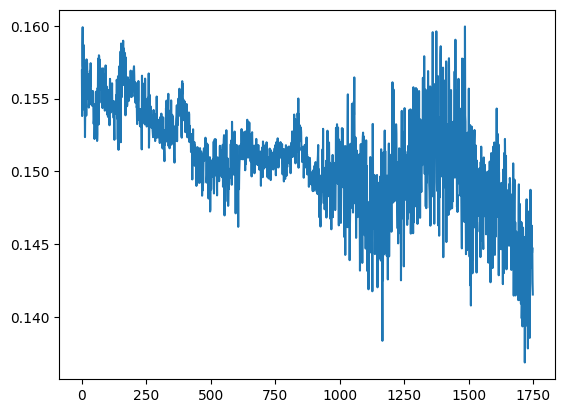

In [ ]:
plt.plot(zeros, label="zeros", alpha=0.5)
plt.plot()

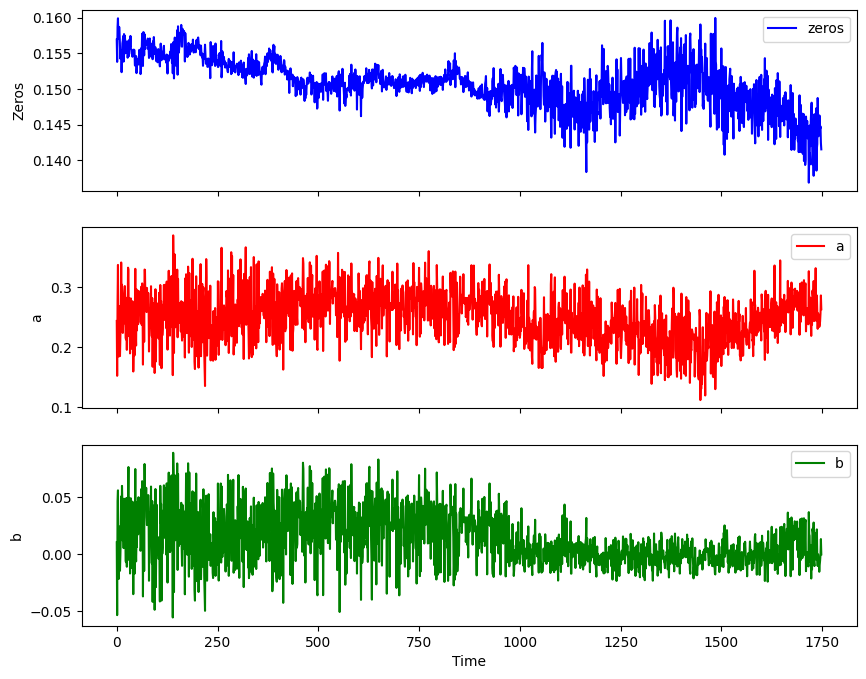

In [20]:
# subplot a b and c
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(c, label="zeros", color="blue")
axs[0].set_ylabel("Zeros")
axs[0].legend()
axs[1].plot(a, label="a", color="red")
axs[1].set_ylabel("a")
axs[1].legend()
axs[2].plot(b, label="b", color="green")
axs[2].set_ylabel("b")
axs[2].legend()
axs[2].set_xlabel("Time")
plt.show()

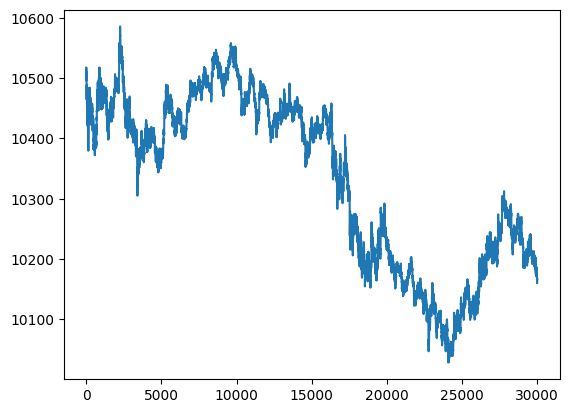

In [8]:
plt.plot(combined["VOLCANIC_ROCK"])

In [10]:
coeffs

array([ 2.62784640e-01, -5.21301504e-05,  1.41530138e-01])